In [3]:
from pathlib import Path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import os


from preprocessing_utils import (
    AREAS,
    _unit_mask,
    subset_S,
    time_window,
    pipeline,
    pipeline_all_specimens,
    get_summary_df
)

In [2]:
zar_dir = Path("../AllenData/neuropixels.zarr/")
ds = xr.open_zarr(zar_dir, consolidated=True)
ds

<xarray.Dataset> Size: 10GB
Dimensions:                          (trials: 50, frame_id: 118,
                                      time_relative_to_stimulus_onset: 25,
                                      units: 8301, dim_0: 118, dim_1: 918,
                                      dim_2: 1174)
Coordinates:
  * frame_id                         (frame_id) int64 944B 0 1 2 ... 115 116 117
    image_selectivity_ns             (units) float64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    run_pval_ns                      (units) float64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    specimen_id                      (units) int64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    splithalf_r_mean                 (time_relative_to_stimulus_onset, units) float64 2MB dask.array<chunksize=(13, 4151), meta=np.ndarray>
    splithalf_r_std                  (time_relative_to_stimulus_onset, units) float64 2MB dask.array<chunksize=(13, 4151), meta=np.ndarray>
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 200B ...
  * trials                           (trials) int64 400B 1 2 3 4 ... 47 48 49 50
    unit_id                          (units) int64 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
    visual_area                      (units) object 66kB dask.array<chunksize=(8301,), meta=np.ndarray>
Dimensions without coordinates: units, dim_0, dim_1, dim_2
Data variables:
    neural_data                      (trials, frame_id, time_relative_to_stimulus_onset, units) float64 10GB dask.array<chunksize=(7, 15, 4, 1038), meta=np.ndarray>
    stimuli                          (dim_0, dim_1, dim_2) uint8 127MB dask.array<chunksize=(15, 230, 294), meta=np.ndarray>

# Esplorazione

In [22]:
import seaborn as sns
from scipy import stats

VISUAL_AREAS = ["VISp", "VISl", "VISal", "VISpm", "VISrl", "VISam"]
VISUAL_AREAS_HIER = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam"]

cmap = sns.color_palette("hls", len(VISUAL_AREAS_HIER))
colors = [cmap[i] for i in range(len(VISUAL_AREAS_HIER))]
VISUAL_AREA_COLOR_MAP = {v: colors[v_idx] for v_idx, v in enumerate(VISUAL_AREAS_HIER)}

def plot_reliability_over_time(
    r_tu,
    fraction_of_max=True
):
    plt.figure(figsize=(8, 5))
    ax = plt.gca()

    time = np.arange(0, 25 * 10, 10)

    for v in VISUAL_AREAS:

        area_mask = ds.visual_area == v
        reliabilities = r_tu[:, area_mask]

        median = np.nanmedian(reliabilities, axis=1)

        if fraction_of_max:
            median = median / np.max(median)

        sem = stats.sem(reliabilities, axis=1, nan_policy="omit")

        ax.fill_between(time, median + sem, median - sem, label=v, alpha=0.8, color=VISUAL_AREA_COLOR_MAP[v])

    if fraction_of_max:
        ax.set_ylabel("Fraction of Maximum Split-half Reliability (Pearson's R)")
    else:    
        ax.set_ylabel("Split-half Reliability (Pearson's R)")
        
    ax.set_xlabel("Time (ms)")
    ax.legend(loc="upper left", frameon=False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.set_xticks(np.arange(0, 25 * 10, 40))


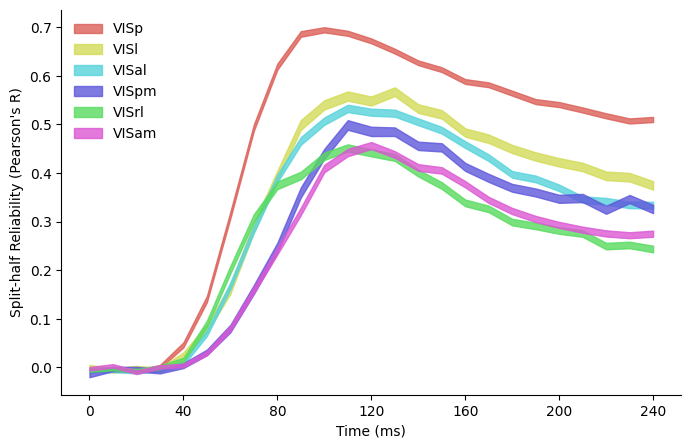

In [23]:
r_tu = ds["splithalf_r_mean"].values                       
plot_reliability_over_time(r_tu, fraction_of_max=False)

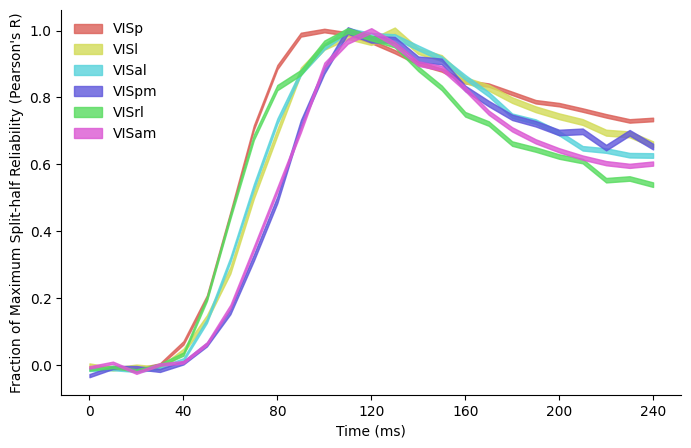

In [24]:
plot_reliability_over_time(r_tu, fraction_of_max=True)

# Preprocessing

Calcolo la split half consistency di ogni unità per ogni time bin. Esiste già tabulata in `ds` $\rho_u(b)$

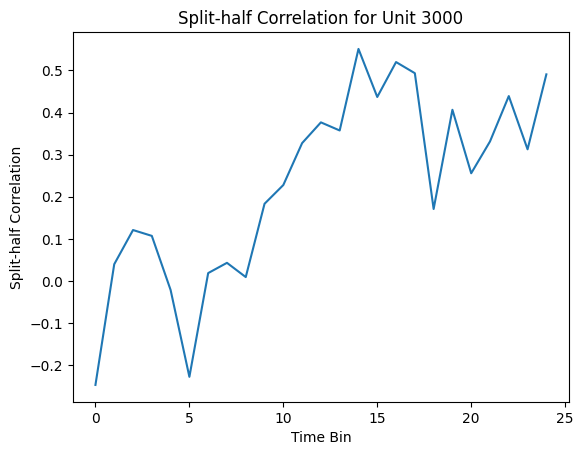

In [26]:
import matplotlib.pyplot as plt

plt.plot(ds["splithalf_r_mean"].values[:, 3000])
plt.xlabel("Time Bin")
plt.ylabel("Split-half Correlation")
plt.title("Split-half Correlation for Unit 3000")
plt.show()

A parità di area, le unità sono tutte diverse tra topi diversi?

Ogni unità ha un id preciso, ed ogni id corrisponde ad un solo neurone per un particolare topo, dunque sono tutti unici.

In [32]:
# area = "VISrl"

for area in AREAS:
    specimens = subset_S(ds, area)

    total_units = 0
    unique_units = set()
    for s in specimens:
        # print(f"Specimen ID: {s}")
        unit_mask_s = _unit_mask(ds, s, area)
        units_in_s = ds.unit_id.values[unit_mask_s]
        # print(f"Units in {area}: {len(units_in_s)}")
        total_units += len(units_in_s)
        unique_units.update(units_in_s)
        # print()

    print(f"Total number of units in {area} across all specimens: {total_units}")
    print(f"Number of unique units in {area} across all specimens: {len(unique_units)}")

Total number of units in VISp across all specimens: 2015
Number of unique units in VISp across all specimens: 2015
Total number of units in VISl across all specimens: 933
Number of unique units in VISl across all specimens: 933
Total number of units in VISal across all specimens: 1553
Number of unique units in VISal across all specimens: 1553
Total number of units in VISpm across all specimens: 879
Number of unique units in VISpm across all specimens: 879
Total number of units in VISrl across all specimens: 1415
Number of unique units in VISrl across all specimens: 1415
Total number of units in VISam across all specimens: 1506
Number of unique units in VISam across all specimens: 1506


Sia un'area $a\in A$ e un certo topo $s\in S(a)$. Fisso una certa unità $u\in U(s,a)$ e per ogni coppia immagine $i\in I$ e trial $t\in T$ colcolo la risposta media nel tempo (sui time bin).

In [35]:
# prendo un topo s in VISp
area = "VISp"
s = subset_S(ds, area)[0]

unit_mask_s = _unit_mask(ds, s, area)
units_in_s = ds.unit_id.values[unit_mask_s]
print(f"Units of specimen {s} in {area}: {units_in_s}")

Units of specimen 699733581 in VISp: [950930145 950930105 950930276 950933698 950930237 950930215 950930358
 950930340 950930437 950930423 950930407 950930392 950930375 950930522
 950930454 950933732 950930866 950930795 950930888 950931118 950931004
 950930985 950934181 950930964 950931043 950931236 950931181 950931164
 950931272 950931254 950931423 950931363 950933840 950931458 950931315
 950931565 950931533 950931517 950931656 950931805 950931617 950931581
 950931770 950931751 950931727 950931853 950931959 950931899 950931878
 950933890 950932102 950932087 950933907 950932032 950933924 950932445
 950932578 950932563 950932696 950933960]


In [36]:
# calcolo la time window per questo topo e area in cui le risposte sono più consistenti (consistenza media su half-split >= 0.3)

start, end = time_window(ds, s, area)

print(f"Time window for specimen {s} in area {area}: {start} to {end}")

Time window for specimen 699733581 in area VISp: 12 to 17


dopo aver calcolato la time window, per ogni coppia $(s,a)$, calcolo la risposta media di ogni unità $u\in U(s,a)$ per ogni immagine $i\in I$ e trial $t\in T$, in quella finestra temporale.

## Pipeline per un topo (per un'area fissata)
La funzione `pipeline` automatizza la precedente procedura, su tutte le unità di una certa area in un certo topo. Restituisce un array 3D di shape (num_units, num_trials, num_images) con le risposte medie nel tempo (sulla finestra definita per quella coppia topo-area) per ogni unità, immagine e trial.

In [37]:
area = "VISp"

s = subset_S(ds, area)[0]

all_responses_s = pipeline(ds, s, area)
print(f"Shape of all responses for specimen {s} in area {area}: {all_responses_s.shape}")

Shape of all responses for specimen 699733581 in area VISp: (50, 118, 60)


## Pipeline su tutti i topi (per un'area fissata)

Secondo la procedura di Nayebi:

1. selezionare solo quelle unità neurali la cui attività massima, evocata dall’immagine a cui sono più sensibili, non dipende dalla velocità con cui il topo corre (run_pval_ns > 0.05).

> Note: questa selezione è sicuramente effettuata da Nayebi sul calcium dataset, ma non è chiaro se sia stata fatta anche sul Neuropixels dataset. 

In [40]:
ds_filtered = ds.where((ds.run_pval_ns > 0.05).compute(), drop=True)
ds_filtered

<xarray.Dataset> Size: 2TB
Dimensions:                          (trials: 50, frame_id: 118,
                                      time_relative_to_stimulus_onset: 25,
                                      units: 4007, dim_0: 118, dim_1: 918,
                                      dim_2: 1174)
Coordinates:
  * frame_id                         (frame_id) int64 944B 0 1 2 ... 115 116 117
    image_selectivity_ns             (units) float64 32kB 0.3579 ... 0.6957
    run_pval_ns                      (units) float64 32kB 0.2234 ... 0.6721
    specimen_id                      (units) int64 32kB 699733581 ... 772616823
    splithalf_r_mean                 (time_relative_to_stimulus_onset, units) float64 801kB dask.array<chunksize=(13, 4007), meta=np.ndarray>
    splithalf_r_std                  (time_relative_to_stimulus_onset, units) float64 801kB dask.array<chunksize=(13, 4007), meta=np.ndarray>
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 200B ...
  * trials                           (trials) int64 400B 1 2 3 4 ... 47 48 49 50
    unit_id                          (units) int64 32kB 950930276 ... 951088476
    visual_area                      (units) object 32kB 'VISp' ... 'VISam'
Dimensions without coordinates: units, dim_0, dim_1, dim_2
Data variables:
    neural_data                      (trials, frame_id, time_relative_to_stimulus_onset, units) float64 5GB dask.array<chunksize=(7, 15, 4, 1037), meta=np.ndarray>
    stimuli                          (dim_0, dim_1, dim_2, units) float32 2TB dask.array<chunksize=(15, 230, 294, 4007), meta=np.ndarray>

In [41]:
# prendo un topo s in VISp
area = "VISp"

s = subset_S(ds_filtered, area)[0]
unit_mask_s = _unit_mask(ds_filtered, s, area)
units_in_s = ds_filtered.unit_id.values[unit_mask_s]
print(f"Units of specimen {s} in {area}: {units_in_s}")

Units of specimen 699733581 in VISp: [950930276 950930237 950930215 950930358 950930340 950930437 950930392
 950930375 950933732 950930866 950930888 950931004 950934181 950930964
 950931236 950931363 950931656 950931878 950932445]


2. applicare la precedente pipeline per ogni topo in quell'area
3. calcolare il numero di unità risultanti per ogni topo, e selezionare solo quei topi che hanno almeno il 75° percentile di unità (per assicurarsi che non ci siano topi con pochissime unità)

questi due step vengono fatti nella funzione `pipeline_all_correct_order`. Secondo la procedura di Nayebi, il filtro sul p-value va fatto prima di tutto, poi la pipeline su ogni topo, e infine il filtro sui topi con poche unità.

In [ ]:
all_responses_v1 = pipeline_all_specimens(ds_filtered, "VISp", threshold=0.3)
if all_responses_v1 is not None:
    print(f"Shape of all responses in VISp after filtering: {all_responses_v1.shape}")

## do it for all areas

In [50]:
for area in AREAS:
    print(f"Processing area: {area}")
    all_responses_area = pipeline_all_specimens(ds, area, threshold=0.3)
    if all_responses_area is not None:
        print(f"Shape of all responses in {area} after filtering: {all_responses_area.shape}")

Processing area: VISp


Processing specimens in VISp: 100%|██████████| 32/32 [00:17<00:00,  1.83it/s]


Shape of all responses in VISp after filtering: (50, 118, 793)
Processing area: VISl


Processing specimens in VISl: 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]


Shape of all responses in VISl after filtering: (50, 118, 336)
Processing area: VISal


Processing specimens in VISal: 100%|██████████| 24/24 [00:08<00:00,  2.99it/s]


Shape of all responses in VISal after filtering: (50, 118, 370)
Processing area: VISpm


Processing specimens in VISpm: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Shape of all responses in VISpm after filtering: (50, 118, 281)
Processing area: VISrl


Processing specimens in VISrl: 100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Shape of all responses in VISrl after filtering: (50, 118, 253)
Processing area: VISam


Processing specimens in VISam: 100%|██████████| 26/26 [00:08<00:00,  2.92it/s]

Shape of all responses in VISam after filtering: (50, 118, 381)


In [ ]:
# join all the *.csv index files into a single dataframe
csv_files = [
    f for f in glob.glob(os.path.join("data", "*.csv"))
    if not f.endswith("combined_index.csv")
]

df_list = [pd.read_csv(f) for f in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv("data/combined_index.csv", index=False)


# Compare with Nayebi's results

In [55]:
summary_df = get_summary_df(combined_df)
summary_df

,Area,Number of Specimen IDs,Total Units,Units per Specimen ID
0,VISal,4,370,"[71, 53, 80, 166]"
1,VISam,5,381,"[70, 94, 71, 72, 74]"
2,VISl,7,336,"[40, 40, 53, 49, 56, 40, 58]"
3,VISp,9,793,"[110, 102, 75, 85, 75, 84, 93, 75, 94]"
4,VISpm,4,281,"[50, 115, 62, 54]"
5,VISrl,4,253,"[67, 68, 60, 58]"


Original table 1 from Nayebi's paper:

| area | total_specimens | total_units |
|------|-----------------|-------------|
| AL   | 6               | 396         |
| AM   | 7               | 257         |
| LM   | 6               | 162         |
| V1   | 8               | 442         |
| PM   | 5               | 175         |
| RL   | 7               | 299         |